<a href="https://colab.research.google.com/gist/cwkx/ef95ceb3184ead1d364246c9047b2aef/dl-generative-model-assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this code is based on [ref], which is released under the MIT licesne
# make sure you reference any code you have studied as above here

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# hyperparameters
batch_size  = 64
n_channels  = 3
latent_size = 512
dataset = 'cifar10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# optional for Colab use only - Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

train_iterator = iter(cycle(train_loader))

Files already downloaded and verified


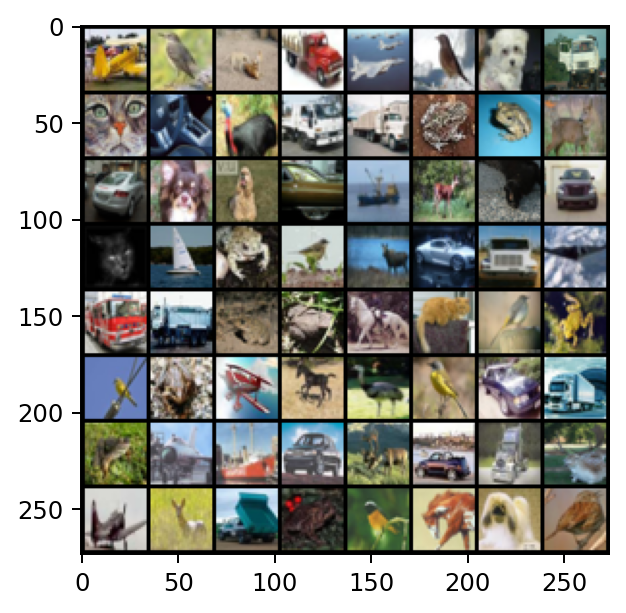

In [ ]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Define a simple convolutional autoencoder**

In [ ]:
# simple block of convolution, batchnorm, and leakyrelu
class Block(nn.Module):
    def __init__(self, in_f, out_f):
        super(Block, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)

# define the model
class Autoencoder(nn.Module):
    def __init__(self, f=16):
        super().__init__()

        self.encode = nn.Sequential(
            Block(n_channels, f),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16 (if cifar10, 48x48 if stl10)
            Block(f  ,f*2),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
            Block(f*2,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
            Block(f*4,latent_size),
        )

        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2), # output = 2x2
            Block(latent_size,f*4),
            nn.Upsample(scale_factor=2), # output = 4x4
            Block(f*4,f*4),
            nn.Upsample(scale_factor=2), # output = 8x8
            Block(f*4,f*2),
            nn.Upsample(scale_factor=2), # output = 16x16
            Block(f*2,f  ),
            nn.Upsample(scale_factor=2), # output = 32x32
            nn.Conv2d(f,n_channels, 3,1,1),
            nn.Sigmoid()
        )

A = Autoencoder().to(device)
print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
optimiser = torch.optim.Adam(A.parameters(), lr=0.001)
epoch = 0

> Number of autoencoder parameters 750147


**Main training loop**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>)


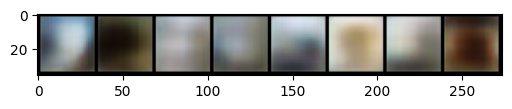

loss tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>)


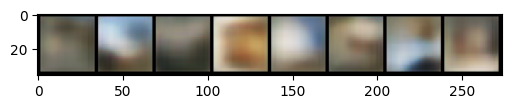

loss tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)


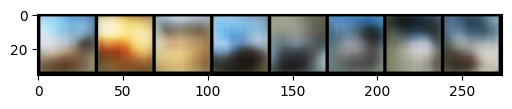

loss tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>)


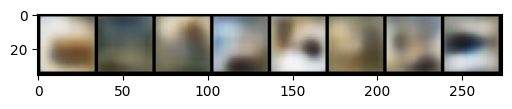

loss tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>)


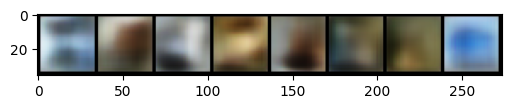

loss tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>)


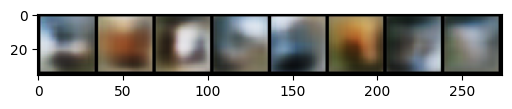

loss tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>)


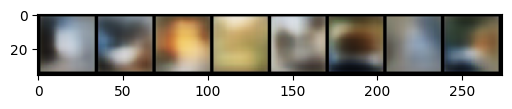

loss tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>)


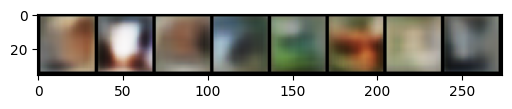

loss tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>)


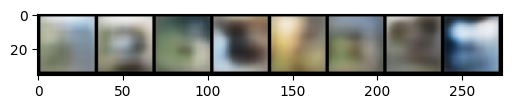

loss tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>)


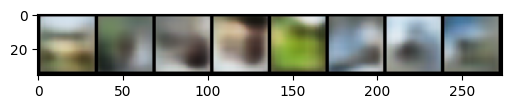

In [ ]:
# training loop, you will want to train for more than 10 here!
while (epoch<10):
    
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(100):

        # sample x from the dataset
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # do the forward pass with mean squared error
        z = A.encode(x)
        x_hat = A.decode(z)
        loss = ((x-x_hat)**2).mean()

        # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # collect stats
        loss_arr = np.append(loss_arr, loss.item())

    # sample your model (autoencoders are not good at this)
    z = torch.randn_like(z)
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1

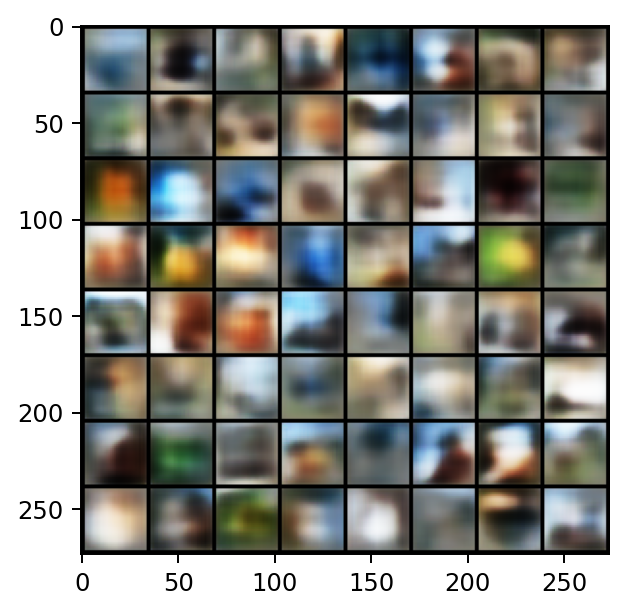

In [ ]:
# now show a batch of data for the submission, right click and save the image for your report
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

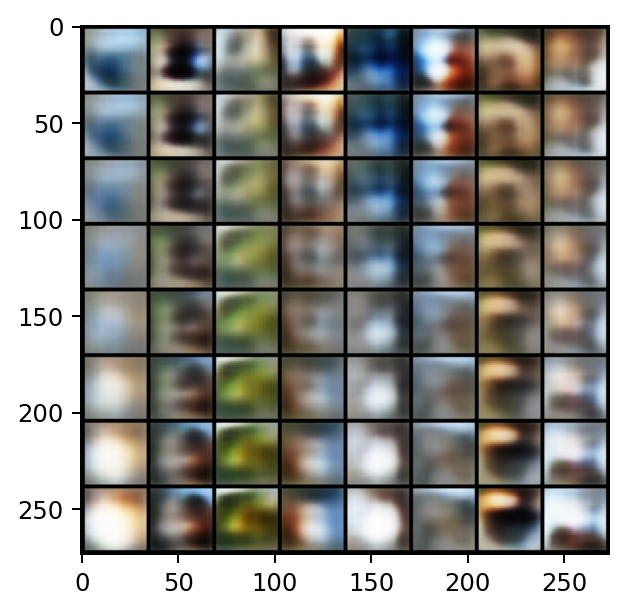

In [ ]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(batch_size))

z0 = z[0:col_size].repeat(col_size,1,1,1) # z for top row
z1 = z[batch_size-col_size:].repeat(col_size,1,1,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1,1,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = A.decode(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# optional example code to save your training progress for resuming later
torch.save({'A':A.state_dict(), 'optimiser':optimiser.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

In [ ]:
# optional example to resume training later
params = torch.load('drive/My Drive/training/save.chkpt')
A.load_state_dict(params['A'])
optimiser.load_state_dict(params['optimiser'])
epoch = params['epoch']